# Code for the Fig 2 and 3 in "Ultrastrong coupling limit to quantum mean force Gibbs state for anharmonic environment"

Authors: Prem Kumar, Sibasish Ghosh

Published Version: https://doi.org/10.1063/5.0223734

arXiv Version: https://arxiv.org/abs/2405.03044v1

This is a faster code that roughly reproduces the fig 2 and 3 of the paper.

# Fig 2 GCL Model

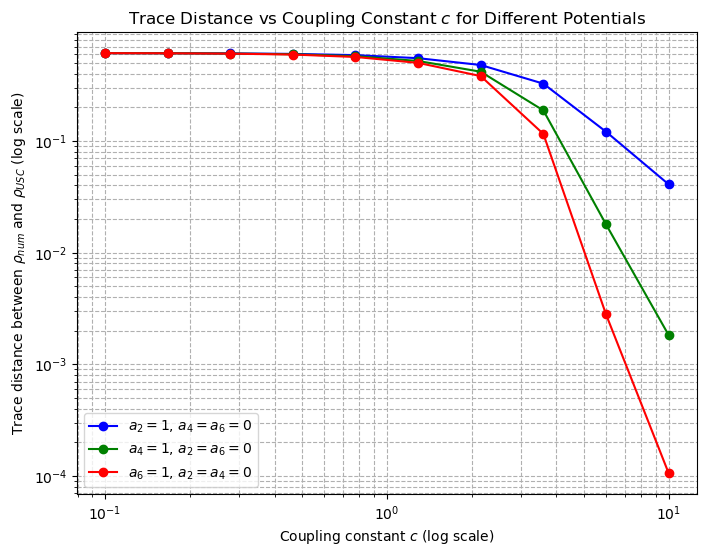

In [2]:
import numpy as np
from scipy.linalg import expm, eigh, svdvals
import matplotlib.pyplot as plt
import concurrent.futures

# Parameters
beta = 5
M = 1
Q_min = -10
Q_max = 10
N = 100  # Number of discretization points
delta_Q = (Q_max - Q_min) / (N - 1)

# System Hamiltonian H_S
H_S = np.array([[1, 1, 0],
                [1, 0, 1],
                [0, 1, -1]])

# System coupling operator A
A = np.array([[1,   0,    0],
              [0,   0,    0],
              [0,   0, -0.5]])

# Identity matrices
I_S = np.eye(3)
I_E = np.eye(N)

# Discretize Q
Q_values = np.linspace(Q_min, Q_max, N)
Q_operator = np.diag(Q_values)

# Kinetic energy operator T using finite difference approximation
T = np.zeros((N, N))
for i in range(N):
    T[i, i] = -2.0
    if i > 0:
        T[i, i - 1] = 1.0
    if i < N - 1:
        T[i, i + 1] = 1.0
T *= -1.0 / (2.0 * M * delta_Q**2)

# Diagonalize the system coupling operator A (for rho_USC)
eigvals_A, eigvecs_A = np.linalg.eigh(A)

# Transform H_S into the eigenbasis of A
H_S_in_A_basis = eigvecs_A.conj().T @ H_S @ eigvecs_A

# Zero out the off-diagonal elements to get H_tilde
H_tilde_in_A_basis = np.diag(np.diag(H_S_in_A_basis))

# Compute the analytical MFGS in the USC limit
rho_USC_in_A_basis = expm(-beta * H_tilde_in_A_basis)

# Normalize the density matrix
Z_USC = np.trace(rho_USC_in_A_basis)
rho_USC_in_A_basis /= Z_USC

# Transform rho_USC back to the original basis
rho_USC = eigvecs_A @ rho_USC_in_A_basis @ eigvecs_A.conj().T

# Range of coupling constants c
c_values = np.logspace(-1, 1, 10)  # From 0.1 to 10, logarithmically spaced

# Potential coefficients for the three cases
potential_coefficients = [
    {'a2': 1, 'a4': 0, 'a6': 0},
    {'a2': 0, 'a4': 1, 'a6': 0},
    {'a2': 0, 'a4': 0, 'a6': 1},
]

# Labels for the plots
labels = [
    '$a_2 = 1$, $a_4 = a_6 = 0$',
    '$a_4 = 1$, $a_2 = a_6 = 0$',
    '$a_6 = 1$, $a_2 = a_4 = 0$'
]

# Colors for the plots
colors = ['blue', 'green', 'red']

# Define the function for computing trace distance at the module level
def compute_trace_distance(args):
    c, a_2, a_4, a_6 = args
    # Construct H_S ⊗ I_E
    H_S_ext = np.kron(H_S, I_E)

    # Construct I_S ⊗ T
    T_ext = np.kron(I_S, T)

    # Construct X = I_S ⊗ Q - c * A ⊗ I_E
    Q_ext = np.kron(I_S, Q_operator)
    A_ext = np.kron(c * A, np.eye(N))
    X = Q_ext - A_ext

    # Compute powers of X
    X2 = X @ X
    V_X = np.zeros_like(X2)
    if a_2 != 0:
        V_X += a_2 * X2
    if a_4 != 0:
        X4 = X2 @ X2
        V_X += a_4 * X4
    if a_6 != 0:
        X4 = X2 @ X2
        X6 = X4 @ X2
        V_X += a_6 * X6

    # Total Hamiltonian H_SE
    H_SE = H_S_ext + T_ext + V_X

    # Compute the exponential exp(-beta * H_SE)
    exp_neg_beta_H_SE = expm(-beta * H_SE)

    # Reshape for partial trace
    exp_neg_beta_H_SE = exp_neg_beta_H_SE.reshape(3, N, 3, N)

    # Compute reduced density matrix by tracing out the environment
    rho_num = np.zeros((3, 3), dtype=np.complex128)
    for m in range(3):
        for n in range(3):
            rho_num[m, n] = np.trace(exp_neg_beta_H_SE[m, :, n, :])

    # Normalize the density matrix
    Z_num = np.trace(rho_num)
    rho_num /= Z_num

    # Compute the trace distance between rho_num and rho_USC
    Delta = rho_num - rho_USC

    # Compute the trace norm (sum of singular values)
    singular_values = svdvals(Delta)
    trace_norm = np.sum(singular_values)

    # Trace distance
    trace_distance = 0.5 * trace_norm

    return trace_distance

# Prepare the plot
plt.figure(figsize=(8, 6))

for coeffs, label, color in zip(potential_coefficients, labels, colors):
    a_2 = coeffs['a2']
    a_4 = coeffs['a4']
    a_6 = coeffs['a6']

    # Prepare list of arguments for parallel computation
    args_list = [(c, a_2, a_4, a_6) for c in c_values]

    # Parallel computation of trace distances using ProcessPoolExecutor
    with concurrent.futures.ProcessPoolExecutor() as executor:
        trace_distances = list(executor.map(compute_trace_distance, args_list))

    # Plot the results
    plt.plot(c_values, trace_distances, marker='o', label=label, color=color)

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coupling constant $c$ (log scale)')
plt.ylabel('Trace distance between $\\rho_{num}$ and $\\rho_{USC}$ (log scale)')
plt.title('Trace Distance vs Coupling Constant $c$ for Different Potentials')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

# Plot 3 (Zwanzig model)

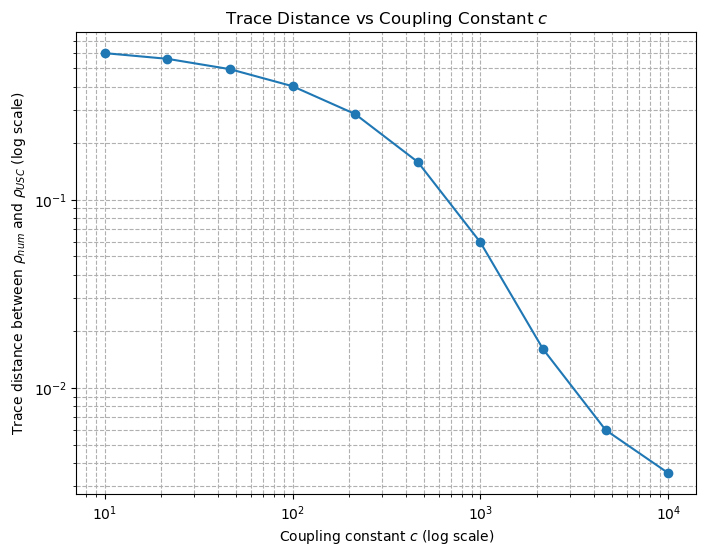

In [3]:
import numpy as np
from scipy.linalg import expm, eigh, svdvals
import matplotlib.pyplot as plt
import concurrent.futures

# Parameters
beta = 5
M = 1
Q_min = -3
Q_max = 3
N = 100  # Number of discretization points
delta_Q = (Q_max - Q_min) / (N - 1)

# System Hamiltonian H_S
H_S = np.array([[1, 1, 0],
                [1, 0, 1],
                [0, 1, -1]])

# System coupling operator A (Assuming q = A)
A = np.array([[1,   0,    0],
              [0,   0,    0],
              [0,   0, -0.5]])

# Identity matrices
I_S = np.eye(3)
I_E = np.eye(N)

# Discretize Q
Q_values = np.linspace(Q_min, Q_max, N)
Q_operator = np.diag(Q_values)

# Kinetic energy operator T using finite difference approximation
T = np.zeros((N, N))
for i in range(N):
    T[i, i] = -2.0
    if i > 0:
        T[i, i - 1] = 1.0
    if i < N - 1:
        T[i, i + 1] = 1.0
T *= -1.0 / (2.0 * M * delta_Q**2)

# Precompute U(Q)
U_operator = (1 - np.exp(-Q_operator)) ** 2

# Diagonalize the system coupling operator A (for rho_USC)
eigvals_A, eigvecs_A = np.linalg.eigh(A)

# Compute U_eff(A_i) = U(A_i)
U_eff = (1 - np.exp(-eigvals_A)) ** 2

# Compute V_0 = sum_i U_eff(A_i) * P_i
V_0_in_A_basis = np.diag(U_eff)

# Transform H_S into the eigenbasis of A
H_S_in_A_basis = eigvecs_A.conj().T @ H_S @ eigvecs_A

# Compute H_tilde = diag(H_S + V_0)
H_tilde_in_A_basis = np.diag(np.diag(H_S_in_A_basis + V_0_in_A_basis))

# Compute the analytical MFGS in the USC limit
rho_USC_in_A_basis = expm(-beta * H_tilde_in_A_basis)

# Normalize the density matrix
Z_USC = np.trace(rho_USC_in_A_basis)
rho_USC_in_A_basis /= Z_USC

# Transform rho_USC back to the original basis
rho_USC = eigvecs_A @ rho_USC_in_A_basis @ eigvecs_A.conj().T

# Range of coupling constants c
c_values = np.logspace(1, 4, 10)  # From 10 to 10000, logarithmically spaced

# Define the function for computing trace distance at the module level
def compute_trace_distance(c):
    # Construct H_S ⊗ I_E
    H_S_ext = np.kron(H_S, I_E)

    # Construct I_S ⊗ T
    T_ext = np.kron(I_S, T)

    # Construct U(Q)
    U_ext = np.kron(I_S, U_operator)

    # Construct Q_ext and A_ext
    Q_ext = np.kron(I_S, Q_operator)
    A_ext = np.kron(A, I_E)

    # Interaction term: (c/2) * (Q_ext - A_ext)^2
    Interaction = (c / 2) * (Q_ext - A_ext) @ (Q_ext - A_ext)

    # Total Hamiltonian H_SE
    H_SE = H_S_ext + T_ext + U_ext + Interaction

    # Compute the exponential exp(-beta * H_SE)
    exp_neg_beta_H_SE = expm(-beta * H_SE)

    # Reshape for partial trace
    exp_neg_beta_H_SE = exp_neg_beta_H_SE.reshape(3, N, 3, N)

    # Compute reduced density matrix by tracing out the environment
    rho_num = np.zeros((3, 3), dtype=np.complex128)
    for m in range(3):
        for n in range(3):
            rho_num[m, n] = np.trace(exp_neg_beta_H_SE[m, :, n, :])

    # Normalize the density matrix
    Z_num = np.trace(rho_num)
    rho_num /= Z_num

    # Compute the trace distance between rho_num and rho_USC
    Delta = rho_num - rho_USC

    # Compute the trace norm (sum of singular values)
    singular_values = svdvals(Delta)
    trace_norm = np.sum(singular_values)

    # Trace distance
    trace_distance = 0.5 * trace_norm

    return trace_distance

# Parallel computation of trace distances using ProcessPoolExecutor
if __name__ == '__main__':
    # This check is necessary on Windows to prevent recursive process spawning
    with concurrent.futures.ProcessPoolExecutor() as executor:
        trace_distances = list(executor.map(compute_trace_distance, c_values))

    # Convert lists to arrays for plotting
    c_values = np.array(c_values)
    trace_distances = np.array(trace_distances)

    # Plotting the trace distance vs c
    plt.figure(figsize=(8, 6))
    plt.plot(c_values, trace_distances, marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Coupling constant $c$ (log scale)')
    plt.ylabel('Trace distance between $\\rho_{num}$ and $\\rho_{USC}$ (log scale)')
    plt.title('Trace Distance vs Coupling Constant $c$')
    plt.grid(True, which='both', ls='--')
    plt.show()